In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

from scipy.optimize import minimize

In [2]:
def Delta_basis(Size = 13):
    kernal = np.zeros((Size,Size))
    x,y = np.where(kernal==0)
    middle = int(len(x)/2)
    basis = []
    for i in range(len(x)):
        b = kernal.copy()
        if (x[i] == x[middle]) & (y[i] == y[middle]):
            b[x[i],y[i]] = 1
        else:
            b[x[i],y[i]] = 1
            b[x[middle],y[middle]] = -1
        basis += [b]
    basis = np.array(basis)
    coeff = np.ones(len(basis))
    return basis, coeff

In [3]:
Ra =  95.4586
Dec = -51.2377
Size = 30
Maglim = 16
Zeropoint = 20.44
tpf = sd.Get_TESS(Ra,Dec,Size)
# pos returned as column row 
pos, gmag = sd.Get_Gaia(tpf,magnitude_limit=Maglim)
col = pos[:,0]
row = pos[:,1]

Tmag = gmag - 0.5
tcounts = 10**(-2/5*(Tmag - Zeropoint))

/Users/rridden/miniconda3/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '


In [4]:
from astropy.convolution import Gaussian2DKernel

In [5]:
a = Gaussian2DKernel(4)#,x_size=13,y_size=13)

In [6]:
a.array

array([[1.11940808e-09, 2.94924749e-09, 7.29945763e-09, ...,
        7.29945763e-09, 2.94924749e-09, 1.11940808e-09],
       [2.94924749e-09, 7.77023220e-09, 1.92315094e-08, ...,
        1.92315094e-08, 7.77023220e-09, 2.94924749e-09],
       [7.29945763e-09, 1.92315094e-08, 4.75984429e-08, ...,
        4.75984429e-08, 1.92315094e-08, 7.29945763e-09],
       ...,
       [7.29945763e-09, 1.92315094e-08, 4.75984429e-08, ...,
        4.75984429e-08, 1.92315094e-08, 7.29945763e-09],
       [2.94924749e-09, 7.77023220e-09, 1.92315094e-08, ...,
        1.92315094e-08, 7.77023220e-09, 2.94924749e-09],
       [1.11940808e-09, 2.94924749e-09, 7.29945763e-09, ...,
        7.29945763e-09, 2.94924749e-09, 1.11940808e-09]])

<IPython.core.display.Javascript object>


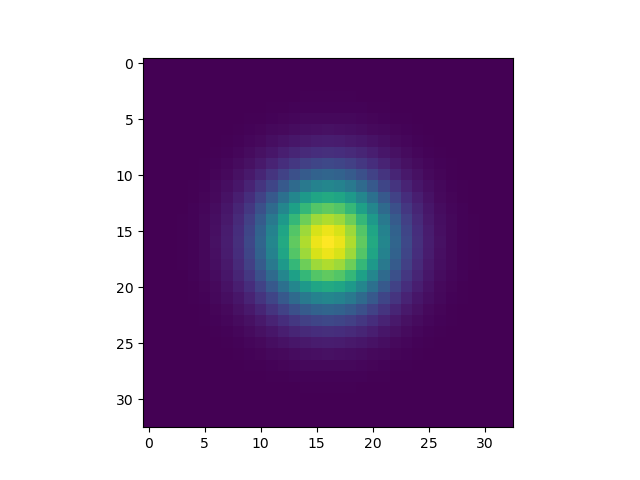

In [7]:
plt.figure()
plt.imshow(a)

In [25]:
Interpolate = False
FFT = True
sources = np.zeros((len(pos),2*tpf.shape[1],2*tpf.shape[2])) #+ bkg
for i in range(len(pos)):
    if Interpolate:
        template = np.zeros((2*tpf.shape[1]*Scale,2*tpf.shape[2]*Scale))
        #print('template shape ',template.shape)
        offset1 = int(0.5 * tpf.shape[1] * Scale)
        offset2 = int(0.5 * tpf.shape[2] * Scale)
        #print(np.nansum(template))
        kernal = Interp_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd,Scale)
        #print(np.nansum(kernal))
        if FFT:
            template[int(row[i]*Scale + offset1),int(col[i]*Scale+ offset2)] = tcounts[i]
            template = signal.fftconvolve(template, kernal, mode='same')
        else:
            optics = kernal * tcounts[i]
            r = int(row[i]*Scale + offset1)
            c = int(col[i]*Scale + offset2)
            template = Add_convolved_sources(r,c,optics,template)
        #print(np.nansum(template))
        template = template[offset1:int(3*offset1),offset2:int(3*offset2)]
        #print('template shape ',template.shape)
        sources[i] = Downsample(template,Scale)

    else:
        template = np.zeros((2*tpf.shape[1],2*tpf.shape[2]))
        kernal = sd.Get_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd)
        kernal = kernal / np.nansum(kernal)
        #print(template.shape)
        offset1 = int(0.5 * tpf.shape[1])
        offset2 = int(0.5 * tpf.shape[2])
        if FFT:
            template[int(row[i] + offset1 ),int(col[i] + offset2)] += tcounts[i]
            #template = signal.fftconvolve(template, kernal, mode='same')
        else:
            optics = kernal * tcounts[i]
            r = int(row[i] + offset1)
            c = int(col[i] + offset2)
            template = Add_convolved_sources(r,c,optics,template)
        #template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]

        sources[i] += template

In [9]:
len(sources)

82

In [10]:
scene = np.nansum(sources,axis=0)

<IPython.core.display.Javascript object>


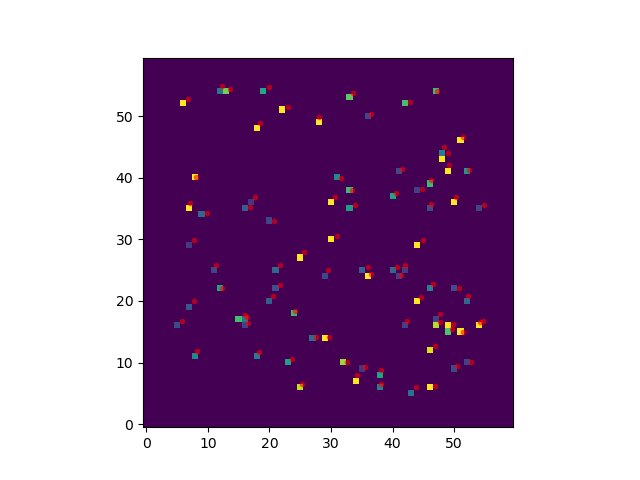

In [11]:
plt.figure()
plt.imshow(scene,origin='lower',vmax=1000)
plt.plot(pos[:,0]+offset1,pos[:,1]+offset2,'r.',alpha=0.5)

In [12]:
t = np.nanmedian(tpf.flux,axis=0)
tt= t - np.percentile(t,15)

<IPython.core.display.Javascript object>


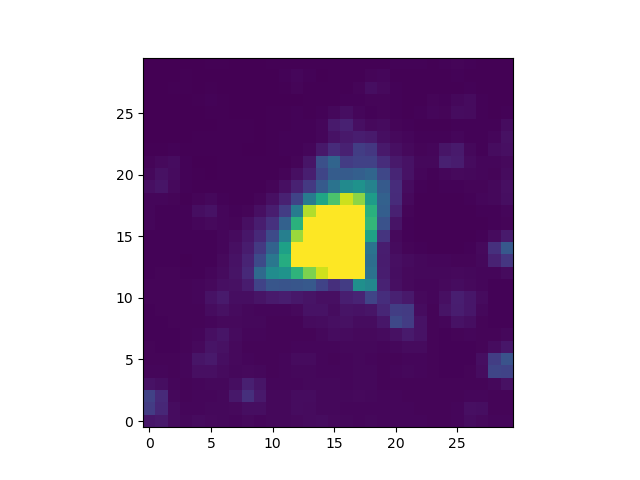

In [13]:
plt.figure()
plt.imshow(tt,origin='lower',vmax=1000)

In [14]:
def Delta_kernal(Scene,Image,Size=13):
    Basis, coeff_0 = Delta_basis(Size)
    bds = []
    for i in range(len(coeff_0)):
        bds += [(0,1)]
    res = minimize(optimize_delta, coeff_0, args=(Basis,Scene,TESS),
                   bounds=bds,options={'disp': True})
    k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
    return k
        
def optimize_delta(Coeff, Basis, Scene, Image):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)
    template = signal.fftconvolve(Scene, Kernal, mode='same')
    template = template #/ np.nanmax(template)
    
    return np.nansum(abs(Image - template))
    
    

In [15]:
def optimize_delta(Coeff, Basis, Scene, TESS):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)
    template = signal.fftconvolve(Scene, Kernal, mode='same')
    template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]

    template = template #/ np.nanmax(template)
    
    tess = TESS.copy() #/ np.nanmax(TESS)
    
    return np.nansum(abs(tess - template))
    
    

In [16]:
from scipy.optimize import minimize
from scipy import signal
from astropy.convolution import Gaussian2DKernel

In [17]:
global Basis, Scene, TESS

In [18]:
TESS = tt.copy()
Scene = scene.copy()


In [19]:
Basis, coeff_0 = Delta_basis(15)
bds = []
for i in range(len(coeff_0)):
    bds += [(0,1)]

In [20]:
res = minimize(optimize_delta, coeff_0, args=(Basis,Scene,TESS),bounds=bds,options={'disp': True})

In [21]:
k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
template = signal.fftconvolve(Scene, k, mode='same')
template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]

<IPython.core.display.Javascript object>


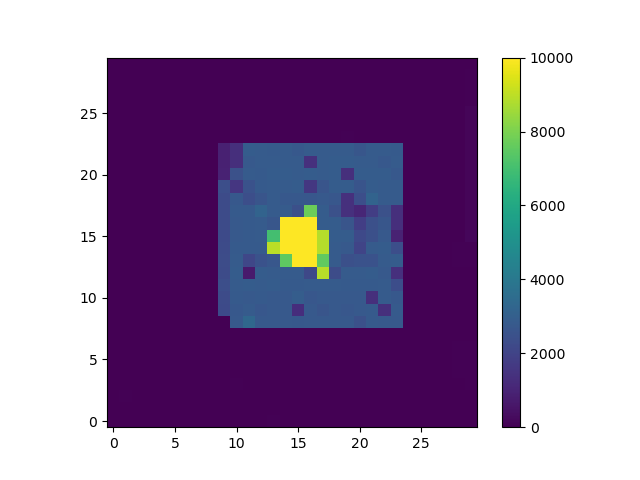

In [23]:
plt.figure()
plt.imshow(template,origin='lower',vmax=10000,vmin=0)
plt.colorbar()
#plt.plot(pos[:,0],pos[:,1],'r.',alpha=0.5)

<IPython.core.display.Javascript object>


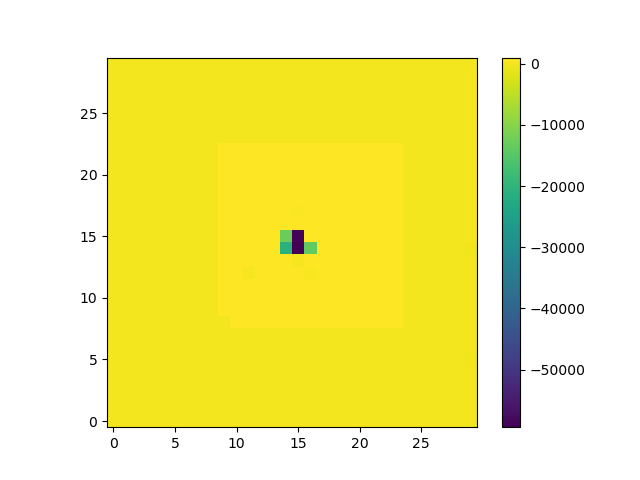

In [24]:
plt.figure()
plt.imshow(template-TESS,origin='lower',vmax=1000)
plt.colorbar()
#plt.plot(pos[:,0],pos[:,1],'r.',alpha=0.5)

<IPython.core.display.Javascript object>


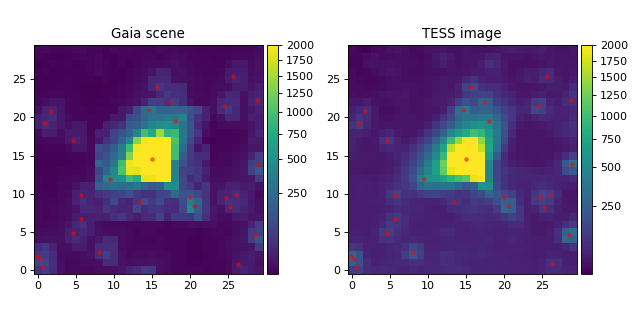

In [50]:
gaia = template

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('Gaia scene')
norm = sd.ImageNormalize(vmin=np.nanmin(gaia), 
                      vmax=2000, stretch=sd.SqrtStretch())
im = plt.imshow(gaia,origin='lower', norm = norm)
plt.xlim(-0.5, Size-0.5)
plt.ylim(-0.5, Size-0.5)
plt.plot(pos[:,0],pos[:,1],'r.',alpha=0.5)
ax = plt.gca()
divider = sd.make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


plt.subplot(1,2,2)	
plt.title('TESS image')
tess = np.nanmedian(tpf.flux,axis=0)
norm = sd.ImageNormalize(vmin=np.nanmin(tess), 
                      vmax=2000, stretch=sd.SqrtStretch())
im = plt.imshow(tess,origin='lower',norm = norm)
plt.xlim(-0.5, Size-0.5)
plt.ylim(-0.5, Size-0.5)
plt.plot(pos[:,0],pos[:,1],'r.',alpha=0.5)
ax = plt.gca()
divider = sd.make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [6]:
minimize(args=)

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

# Include position in the fit

In [79]:
def High_res(Displacement,Position, tpf, Scale =100):
    position = Position.copy()
    row = position[:,0] + Displacement[0]
    col = position[:,1] + Displacement[1]
    FFT = False
    sources = np.zeros((len(position),2*tpf.shape[1],2*tpf.shape[2]))
    for i in range(len(position)):
        template = np.zeros((2*tpf.shape[1]*Scale,2*tpf.shape[2]*Scale))
        #print('template shape ',template.shape)
        offset1 = int(0.5 * tpf.shape[1] * Scale)
        offset2 = int(0.5 * tpf.shape[2] * Scale)
        r = int(row[i]*Scale + offset1)
        c = int(col[i]*Scale + offset2)
        if (r > 0) & (c > 0) & (r < template.shape[0]) & (c < template.shape[1]):
            #print(np.nansum(template))
            #kernal = Interp_PRF(row[i] + tpf.row, col[i] + tpf.column,tpf.camera,tpf.ccd,Scale)
            kernal = Gaussian2DKernel(4).array
            #print(np.nansum(kernal))
            if FFT:
                template[r,c] += tcounts[i]
                template = signal.fftconvolve(template, kernal, mode='same')
            else:
                optics = kernal * tcounts[i]

                template = sd.Add_convolved_sources(r,c,optics,template)
            #print(np.nansum(template))
            #template = template[offset1:int(3*offset1),offset2:int(3*offset2)]
            #print('template shape ',template.shape)
            sources[i] = sd.Downsample(template,Scale)
    return sources 

In [84]:
def optimize_delta_high_res(Coeff, Basis, Positions, TPF):
    coeff = Coeff[:-2]
    displacement = Coeff[-2:]
    sauce = High_res(displacement,Positions,TPF)
    Scene = np.nansum(sauce,axis=0)
    Kernal = np.nansum(coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)
    print('kernal',Kernal.shape)
    print('scene',Scene.shape)
    template = signal.fftconvolve(Scene, Kernal, mode='same')
    template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]
    
    tess = np.nanmedian(TPF.flux,axis=0)
    tess = tess - np.percentile(tess,15)
    
    return np.nansum(abs(tess - template))
    
    

In [85]:
Basis, coeff_0 = Delta_basis(15)
bds = []
for i in range(len(coeff_0)):
    bds += [(0,1)]
coeff_0 = np.append(coeff_0,[1,1])
bds += [(-1,1)]
bds += [(-1,1)]

In [86]:
res = minimize(optimize_delta_high_res, coeff_0, args=(Basis,pos,tpf),bounds=bds,options={'disp': True})

kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (15, 15)
scene (60, 60)
kernal (

KeyboardInterrupt: 